In [118]:
#imports
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

import scipy as sp
import scipy.linalg as spl
import scipy.stats as sps

import pandas as pd

import matplotlib.pyplot as plt

In [41]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from our_package import * #allows us to use our functions directly

In [4]:
#we call the different functions
T = 5
Lambda = 1

D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T, a, b)
Y = Computation_Y(T, Lambda)
x,x_tilde = ComputeArgmax(T,Lambda, Y)
mu,mu_tilde = ComputeMeans(T,Lambda, Y)
q1 = ComputeQuantiles(T,Lambda,0.975*np.ones(T), Y)
q2 = ComputeQuantiles(T,Lambda,0.025*np.ones(T), Y)
med = ComputeQuantiles(T,Lambda,0.5*np.ones(T), Y)
sim_theta,sim_theta_tilde,sim_accepts,sim_gammas = MetropolisHastings(T,Lambda, Y)
Mean=np.sum(sim_theta,axis=0)/sim_theta.shape[0]
q = np.array([2.5,50,97.5])
quantiles_emp = Quantiles(sim_theta_tilde, q,T)

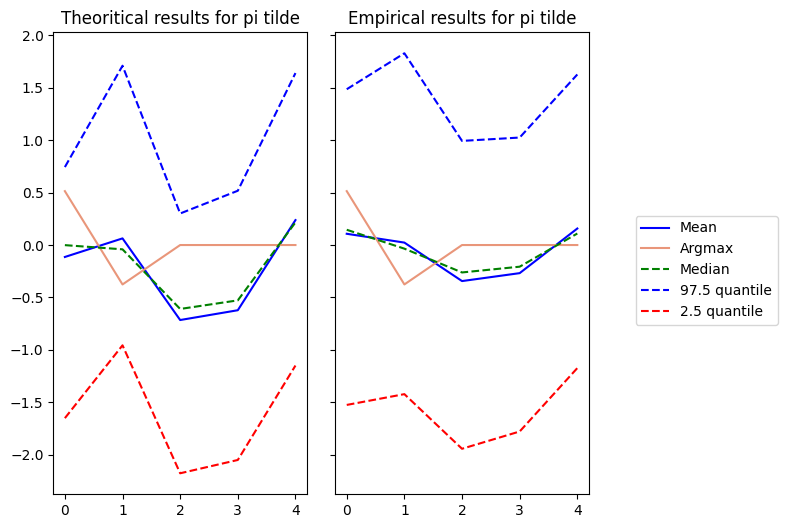

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), sharey=True)
#Plot of theoritical results
axes[0].plot(mu_tilde,color="blue",label="Mean")
axes[0].plot(x_tilde,color="darksalmon",label="Argmax")
axes[0].plot(med,'g--',label="Median")
axes[0].plot(q1,'b--',label="97.5 quantile")
axes[0].plot(q2,'r--',label="2.5 quantile")
axes[0].set_title("Theoritical results for pi tilde")


#Plot of empirical results
axes[1].plot(D@Mean,color="blue")
axes[1].plot(x_tilde,color="darksalmon")
axes[1].plot(quantiles_emp[1],'g--')
axes[1].plot(quantiles_emp[2],'b--')
axes[1].plot(quantiles_emp[0],'r--')
axes[1].set_title("Empirical results for pi tilde")

# Shrink current axis by 20%
box0,box1 = axes[0].get_position(),axes[1].get_position()
axes[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
axes[1].set_position([box1.x0*0.8, box1.y0, box1.width * 0.8, box1.height])
fig.legend(loc=(0.8*box1.x0+box1.width,box1.height/2))
plt.show()

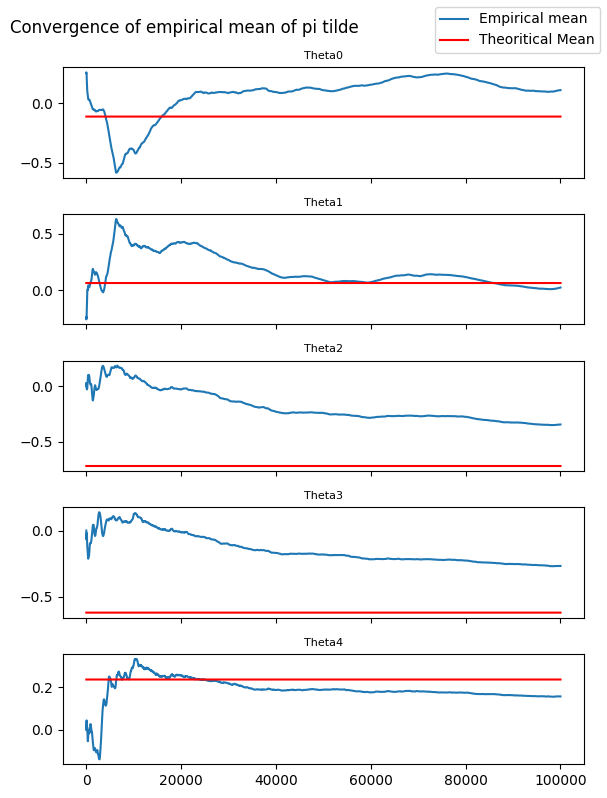

In [13]:
#Convergence plot of the mean of theta_tilde
nb_iter=sim_theta.shape[0]
x=np.linspace(1,nb_iter,nb_iter)
mean_tab=np.cumsum(sim_theta_tilde,axis=0)

fig,Axes = plt.subplots(T,1,figsize=(6,8),sharex=True)
for i in range(T):
    ax = Axes[i]
    res=mean_tab[:,i]/x
    ax.plot(x,res,label="Empirical mean" if i==0 else "")
    ax.plot(x,mu_tilde[i]*np.ones(nb_iter),'r',label="Theoritical Mean" if i==0 else "")
    ax.set_title(f"Theta{i}",fontsize=8)

fig.suptitle("Convergence of empirical mean of pi tilde", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

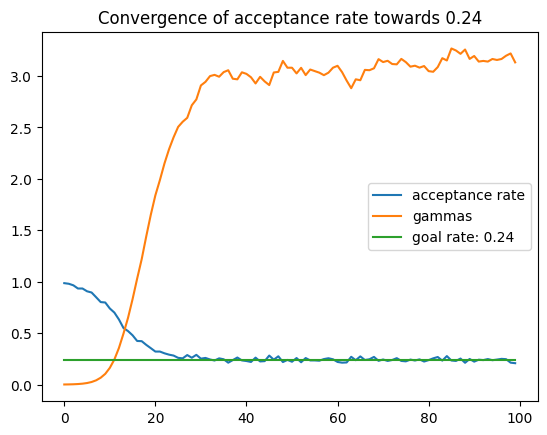

In [18]:
plt.plot(sim_accepts,label="acceptance rate")
plt.plot(sim_gammas[:-1],label="gammas")
plt.plot(np.ones(len(sim_accepts))*0.24,label="goal rate: 0.24")
plt.title("Convergence of acceptance rate towards 0.24")
plt.legend()
plt.show()

In [127]:
Lambdas = [0.1,0.5,0.8,1,1.3,1.6,2,4,7,9]
T = 5
niter = 1e5
n = len(Lambdas)
sim_theta_tildes = np.zeros((T,n))
npr.seed(42)

for k in range(n):
    L = Lambdas[k]
    Y = Computation_Y(T, Lambda)
    _, sim_theta_tildes[:,k] = MetropolisHastingsFast(T, Lambda, Y,niter=niter)
    print(f"Oooh yeah! Finished {k}th iteration")

Oooh yeah! Finished 0th iteration
Oooh yeah! Finished 1th iteration
Oooh yeah! Finished 2th iteration
Oooh yeah! Finished 3th iteration
Oooh yeah! Finished 4th iteration
Oooh yeah! Finished 5th iteration
Oooh yeah! Finished 6th iteration
Oooh yeah! Finished 7th iteration
Oooh yeah! Finished 8th iteration
Oooh yeah! Finished 9th iteration


C:\Users\vetle\OneDrive\Dokumenter\4MIC-S2\mcmc-epidemic\our_package.py:84: RuntimeWarning: divide by zero encountered in divide
  mu_tilde_minus = mu_minus + np.exp(-((sh+mu_minus)**2)/2) / (np.sqrt(2*np.pi)*C_minus)
C:\Users\vetle\OneDrive\Dokumenter\4MIC-S2\mcmc-epidemic\our_package.py:85: RuntimeWarning: invalid value encountered in multiply
  mu_tilde = gamma*mu_tilde_plus + (1-gamma)*mu_tilde_minus


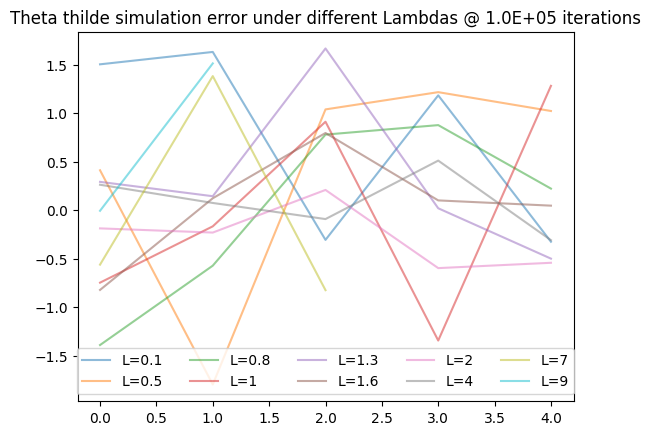

In [130]:
errors = np.zeros(np.shape(sim_theta_tildes))
for k in range(n):
    Y = Computation_Y(T, Lambda)
    _, theoretical_means = ComputeMeans(T, Lambdas[k], Y)
    errors[:,k] = sim_theta_tildes[:,k] - theoretical_means

plt.title(f"Theta thilde simulation error under different Lambdas @ {niter:.1E} iterations")
for k in range(n):
    plt.plot(errors[:,k], label=f"L={Lambdas[k]}",alpha=0.5)
plt.legend(ncols=n//2,loc="lower center")
plt.show()

In [207]:
print(np.shape(errors))
df = pd.DataFrame(errors.T)
df.insert(0,"lambda",Lambdas)
df["AVG"] = df.drop(columns="lambda").apply(npl.norm, ord=1, axis=1)
df["MAX"] = df.drop(columns=["lambda","AVG"]).apply(npl.norm, ord=np.inf, axis=1)

(5, 10)


In [204]:
def color_smallest_sum_row(df, color='yellow'):
    def highlight(row):
        last_two = row.iloc[-2:]
        if last_two.isna().any():
            return [''] * len(row)
        
        last_two_sum = last_two.sum()
        valid_rows = df.iloc[:, -2:].dropna()
        if valid_rows.empty:
            return [''] * len(row)
        
        min_sum = valid_rows.sum(axis=1).min()
        return ['background-color: ' + color if last_two_sum == min_sum else '' for _ in row]
    
    return df.style.apply(highlight, axis=1)


In [206]:
styled_df = color_smallest_sum_row(df, color='lightblue')
styled_df

,lambda,0,1,2,3,4,AVG,MAX
0,0.100000,1.504437,1.632122,-0.305743,1.184602,-0.324787,4.951692,1.632122
1,0.500000,0.411916,-1.796718,1.039624,1.217485,1.023224,5.488968,1.796718
2,0.800000,-1.389997,-0.571596,0.779876,0.877639,0.222866,3.841973,1.389997
3,1.000000,-0.746781,-0.166120,0.912600,-1.343697,1.282406,4.451604,1.343697
4,1.300000,0.292468,0.144483,1.667827,0.020146,-0.499099,2.624022,1.667827
5,1.600000,-0.821768,0.123354,0.796477,0.101304,0.047171,1.890074,0.821768
6,2.000000,-0.187171,-0.230417,0.209242,-0.596843,-0.541935,1.765609,0.596843
7,4.000000,0.262788,0.074971,-0.091203,0.511651,-0.308471,1.249084,0.511651
8,7.000000,-0.560992,1.382946,-0.824203,nan,nan,nan,nan
9,9.000000,-0.005695,1.513765,nan,nan,nan,nan,nan
